In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
import keras


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.6.2


In [6]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

Working Directory Contents: ['NonDemented', 'VeryMildDemented', 'ModerateDemented', 'MildDemented']


In [7]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [8]:
train_data, train_labels = next(train_data_gen)
train_data.shape, train_labels.shape

((6400, 176, 176, 3), (6400, 4))

In [9]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
# Model Architecture

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(176, 176, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
], name = "AlexNet")

In [13]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [14]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4),
           tf.keras.metrics.Recall(name='recall')]

CALLBACKS = [my_callback, rop_callback]
    
model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

model.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 42, 42, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 42, 42, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 20, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 384)         8851

In [15]:
%%time
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), callbacks=CALLBACKS, epochs=EPOCHS)

2022-04-11 14:21:57.091398: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3045064704 exceeds 10% of free system memory.
2022-04-11 14:22:00.107143: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3045064704 exceeds 10% of free system memory.
2022-04-11 14:22:02.439686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-11 14:22:05.425546: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


256/256 [==============================] - ETA: 0s - loss: 5.7872 - acc: 0.2617 - auc: 0.5133 - f1_score: 0.2605 - recall: 0.0967

2022-04-11 14:22:18.204343: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 761266176 exceeds 10% of free system memory.
2022-04-11 14:22:19.030355: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 761266176 exceeds 10% of free system memory.


256/256 [==============================] - 18s 38ms/step - loss: 5.7872 - acc: 0.2617 - auc: 0.5133 - f1_score: 0.2605 - recall: 0.0967 - val_loss: 55.3819 - val_acc: 0.2612 - val_auc: 0.5055 - val_f1_score: 0.1054 - val_recall: 0.2607
Epoch 2/50
256/256 [==============================] - 8s 30ms/step - loss: 1.3634 - acc: 0.3951 - auc: 0.6763 - f1_score: 0.3914 - recall: 0.2125 - val_loss: 2.8185 - val_acc: 0.2461 - val_auc: 0.5397 - val_f1_score: 0.1234 - val_recall: 0.2114
Epoch 3/50
256/256 [==============================] - 8s 30ms/step - loss: 0.9776 - acc: 0.5355 - auc: 0.8260 - f1_score: 0.5330 - recall: 0.3835 - val_loss: 2.3173 - val_acc: 0.3682 - val_auc: 0.6656 - val_f1_score: 0.2393 - val_recall: 0.2573
Epoch 4/50
256/256 [==============================] - 8s 30ms/step - loss: 0.8965 - acc: 0.5797 - auc: 0.8556 - f1_score: 0.5777 - recall: 0.4291 - val_loss: 11.5600 - val_acc: 0.2612 - val_auc: 0.5252 - val_f1_score: 0.1118 - val_recall: 0.2568
Epoch 5/50
256/256 [========

In [16]:
model.save("/kaggle/working/AlexNet", save_format = 'h5')

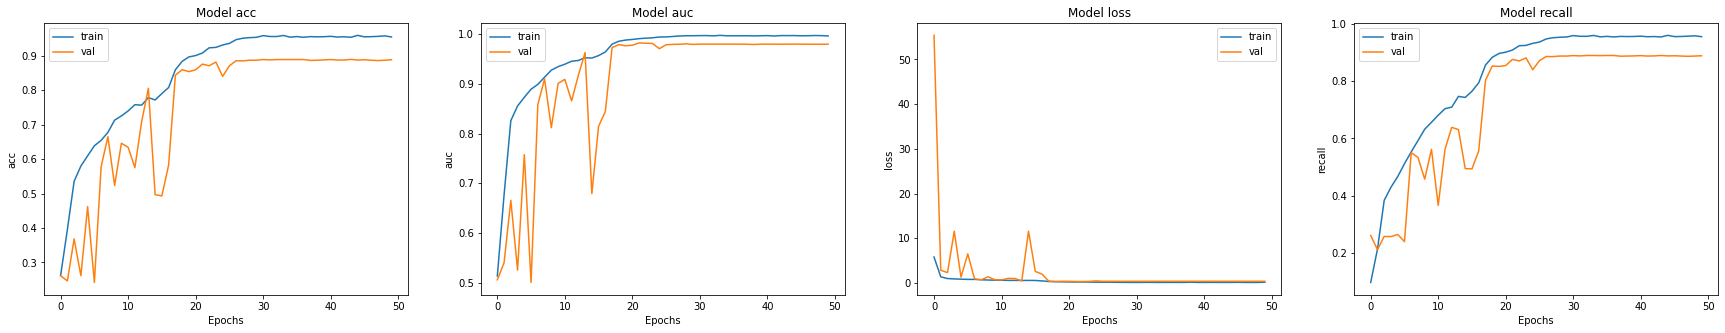

In [18]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 4, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss", "recall"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
plt.savefig("/kaggle/working/AlexNetResults", bbox_inches ="tight", dpi=600)

In [23]:
d = {
    "Accuracy": history.history["acc"],
    "AUC": history.history["auc"],
    "Loss": history.history["loss"],
    "Recall": history.history["recall"],
    "Val Accuracy": history.history["val_acc"],
    "Val AUC": history.history["val_auc"],
    "Val Loss": history.history["val_loss"],
    "Val Recall": history.history["val_recall"]    
}

df = pd.DataFrame(d)
df

,Accuracy,AUC,Loss,Recall,Val Accuracy,Val AUC,Val Loss,Val Recall
0,0.261719,0.513346,5.787167,0.096680,0.261230,0.505547,55.381870,0.260742
1,0.395142,0.676264,1.363373,0.212524,0.246094,0.539739,2.818467,0.211426
2,0.535522,0.825971,0.977639,0.383545,0.368164,0.665589,2.317255,0.257324
3,0.579712,0.855619,0.896482,0.429077,0.261230,0.525183,11.560005,0.256836
4,0.609497,0.872899,0.837717,0.466309,0.461914,0.757452,1.291127,0.264160
5,0.638794,0.889367,0.787288,0.511230,0.241699,0.500297,6.492119,0.239258
6,0.654419,0.898959,0.787089,0.552612,0.577637,0.858212,0.928529,0.549805
7,0.677490,0.913493,0.706497,0.591919,0.665039,0.910020,0.696001,0.533203
8,0.713135,0.927641,0.651099,0.631592,0.523438,0.811819,1.374794,0.457520
9,0.725464,0.934639,0.612086,0.656006,0.645996,0.900885,0.713779,0.561523


In [25]:
df.to_csv("/kaggle/working/alexnet_results.csv", index=False)

In [19]:
os.listdir("/kaggle/working")

['AlexNetResults.png', 'dataset', 'AlexNet', '__notebook_source__.ipynb']